# Evaluación y Uso de YOLO para Detección de Objetos

## Introducción

En este proyecto, exploramos y evaluamos el rendimiento del modelo **YOLO (You Only Look Once)** para la detección de objetos en imágenes. Dado que YOLO utiliza una arquitectura ViT para la detección en imágen devolviendo bounding boxes, es ideal para empezar viendo el funcionamiento de modelos en hugging face

El objetivo principal de este trabajo es comprobar la funcionalidad de YOLO y practicar su implementación en Jupiter Notebook para familiarizarnos con las herramientas

## Objetivos

- Implementar y probar el modelo **YOLO** en imágenes de prueba.
- Entrenar el modelo en un conjunto de datos propuesto y evaluar su rendimiento.
- Practicar con todo ello implementaciones y evaluacion de modelos en Hugging Face

¡Comencemos con la evaluación del modelo!

**Comprobar el modelo**

Para ello seguiremos los siguientes pasos

1. Elegimos un dataset apropiado
2. Procesamos los datos para cumplir con el formato de entrada del modelo
3. Entrenamos el modelo
4. Evaluamos el rendimiento

### 1 Elegir un dataste apropiado

En este caso usaremos COCO, es un dataset de imágenes muy utilizado y escojemos este ya que es el usado por los propios creadores del modelo para evaluar su rendimiento, por lo que trataremos de imitar su experimento

COCO tiene una estructura particular en la que la información de cada imagen viene en un JSON, los detalles del formato se pueden encontrar [aquí](https://cocodataset.org/#format-data). Pero esencialmente buscamos crear un diccionario con las imagenes, id, bbx y clase para poder cargarlo en el Dataloader

In [1]:
from utils import COCODataProcessor
COCO_DIR = 'datasets/COCO_2017'

coco_data = COCODataProcessor(f'{COCO_DIR}/annotations/instances_train2017.json', 
                              f'{COCO_DIR}/train2017')

print(f"coco train annotations: {coco_data.json['annotations'][0]}")
print(f"coco train images: {coco_data.json['images'][0]}")

coco train annotations: {'segmentation': [[239.97, 260.24, 222.04, 270.49, 199.84, 253.41, 213.5, 227.79, 259.62, 200.46, 274.13, 202.17, 277.55, 210.71, 249.37, 253.41, 237.41, 264.51, 242.54, 261.95, 228.87, 271.34]], 'area': 2765.1486500000005, 'iscrowd': 0, 'image_id': 558840, 'bbox': [199.84, 200.46, 77.71, 70.88], 'category_id': 58, 'id': 156}
coco train images: {'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}


Como podemos observar tenemos una cantiadad suficiente de datos por lo que ya que este ejercicio es para familiarizarnos con el proceso vamos a partir de este dataset coger unos splits de train test y validation mucho menores para ver el resultado

In [2]:
print(coco_data.get_shape())

(118287, 3)


Estos splits se hacen utilizando los ids de las imagenes que son las keys del diccionario, y una vez repartidas aleatoriamente estas keys, creamos unos nuevos diccionarios con las entradas de los diccionarios.

{'image_path': 'datasets/COCO_2017/train2017/000000076026.jpg', 'bbox': [15.86, 141.98, 376.21, 422.34], 'category_id': 25}
{'image_path': 'datasets/COCO_2017/train2017/000000557130.jpg', 'bbox': [41.29, 244.84, 45.5, 14.37], 'category_id': 75}
{'image_path': 'datasets/COCO_2017/train2017/000000039163.jpg', 'bbox': [244.88, 263.03, 179.67, 286.44], 'category_id': 86}
{'image_path': 'datasets/COCO_2017/train2017/000000301018.jpg', 'bbox': [286.19, 152.73, 13.08, 14.38], 'category_id': 1}
{'image_path': 'datasets/COCO_2017/train2017/000000532482.jpg', 'bbox': [419.97, 68.16, 14.45, 24.76], 'category_id': 1}
{'image_path': 'datasets/COCO_2017/train2017/000000376965.jpg', 'bbox': [5.86, 106.44, 234.01, 323.56], 'category_id': 1}
{'image_path': 'datasets/COCO_2017/train2017/000000143158.jpg', 'bbox': [54.81, 223.33, 87.26, 147.55], 'category_id': 1}
{'image_path': 'datasets/COCO_2017/train2017/000000555309.jpg', 'bbox': [219.28, 225.32, 123.64, 40.14], 'category_id': 8}
{'image_path': 'data

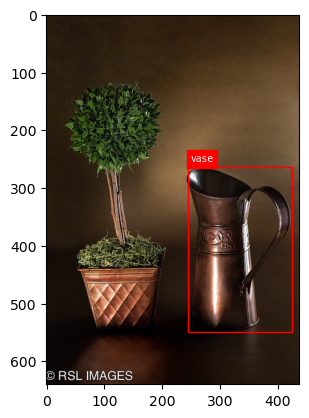

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random

# random_num = random.randint(1, 500)
random_num = 123

TRAIN_SIZE = 10
VAL_SIZE = 2
TEST_SIZE = 1

# Convertimos el dataset en un array de indices de imagenes para hacer el split mas eficientemente
image_ids = list(coco_data.image_dict.keys())

# Obtenemos la cantidad de imagenes con las que queremos trabajar aleatriamente
selected_ids = np.random.choice(image_ids, size=TRAIN_SIZE+VAL_SIZE+TEST_SIZE, replace=False)

# Separamos Test del conjunto de imagenes
train_val_ids, test_ids = train_test_split(selected_ids, test_size=TEST_SIZE, random_state=random_num)

# Separamos validation de train y terminamos con los 3 conjuntos
train_ids, val_ids = train_test_split(train_val_ids, test_size=VAL_SIZE, random_state=random_num)

# Obtenemos los dataset conteniendo cada uno las imagenes seleccionadas
dtrain = coco_data.dataset_from_dict_ids(train_ids)
dval = coco_data.dataset_from_dict_ids(val_ids)
dtest = coco_data.dataset_from_dict_ids(test_ids)

for data in dtrain:
    print(data)

# finalmente vemos unos ejemplos del contenido del dataset
print(f"Shapes: Train: {dtrain.shape}, Test: {dtest.shape}, Validation: {dval.shape}")
print(f"image class num: {coco_data.image_dict[train_ids[0]]["category_id"]}")
coco_data.show_image(train_ids[0])


Una vez creados los dataset vamos a crear los tensores con la información en formato de YOLO.

Este modelo utiliza de **input las imágenes** por el contrario de **output** tenemos las **bounding boxes y sus clases de COCO**

In [4]:
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset as DtLib
import torch

BATCH_SIZE = 10

torch.manual_seed(1)    # definimos una semilla de aleatoriedad 

train_loader = DataLoader(dtrain, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dval, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
from transformers import YolosForObjectDetection, YolosImageProcessor

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-base')
processor = YolosImageProcessor.from_pretrained('hustvl/yolos-base')

Ahora podemos pasar a la fase de entrenamiento

In [6]:
model.train()   # ponemos el modelo en modo entrenamiento

YolosForObjectDetection(
  (vit): YolosModel(
    (embeddings): YolosEmbeddings(
      (patch_embeddings): YolosPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (interpolation): InterpolateInitialPositionEmbeddings()
    )
    (encoder): YolosEncoder(
      (layer): ModuleList(
        (0-11): 12 x YolosLayer(
          (attention): YolosSdpaAttention(
            (attention): YolosSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): YolosSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )


### Loss function

Como este es un problema con **distintos tipos de salidas** deberemos usar una loss function mas compleja. Esta se compone de los siguientes componentes:

- Error de la bbox con ***SmoothL1*** ya que buscamos la distancia errada
- Error en la clase con ***CrossEntropy*** como es habitual

Estos errores son sumados, multiplicamos el error de las bbox por una constante *lambda* para darle mas o menos importanica, en nuestro caso es mas importante que la clase, por lo que de base será un 1,5

Usamos *L1* ya que las bbox pueden tener errores muy grandes y es preferible evitar que el modelo fluctuie mucho con estas como pasaria con L2


In [7]:
import torch.nn as nn

def compute_loss(pred, label, bboxes, model, class_loss_fn, bbox_lambda=1.5):
    """
    : class_loss_fn corresponde a torch.nn.CrossEntropy
    """
    logits = pred.logits   # [batch_size, 100, 92] -> num queries, num_clases
    batch_size, num_queries, num_classes = logits.shape

    # vamos a obtener la clase con mas confianza para cada imagen del batch
    # Aplicamos softmax para normalizar y obtener probabilidades
    probs = torch.softmax(logits, dim=-1)   # [batch_size, 100, 92]
    
    # Encontramos la mejor query por imagen (la que tiene la mayor probabilidad)
    best_query_idx = probs.max(dim=-1)[0].argmax(dim=-1)  # [batch_size]

    # Extraemos la mejor predicción de clase por imagen
    best_logits = logits[torch.arange(batch_size), best_query_idx, :]  # [batch_size, num_classes]
    
    # Perdida de la clasificacion
    # Ajustamos labels al tamaño por si acaso
    targ_labels = label.view(-1)

    # Finalmente calculamos la pérdida de clasificación
    class_loss = class_loss_fn(best_logits, targ_labels)  # CrossEntropyLoss


    # # Ajustamos shape para ser N, num_clases / N=batch_size*num_queries
    # #              .view(-1, logits.shape[-1])
    # print("Labels dtype:", targ_labels.dtype)
    # print("Labels shape:", targ_labels.shape)  # Debería ser [batch_size]
    # print("Logits shape:", pred_labels.shape)
    # print("Logits shape:", pred_labels.dtype)
    # class_loss = class_loss_fn(pred_labels, targ_labels)

    # Perdida en bbox
    # Si no existen las bbox le asignamos un tensor de ceros (1,4) bbox tiene formato [cx, cy, w, h]
    bbox_pred = getattr(pred, "pred_boxes", None)

    if bbox_pred is None:
        loss_bbox = torch.tensor.zeros_like(bboxes, device=model.device)
    else:
        # Obtenemos la bbox de la query con mejor probabilidad
        best_bboxes_pred = bbox_pred[torch.arange(batch_size), best_query_idx, :]  # [batch_size, 4]
        loss_bbox = nn.functional.smooth_l1_loss(best_bboxes_pred, bboxes)



    loss = bbox_lambda * loss_bbox + class_loss
    return loss

## Entrenamiento

Utilizaremos de optimizador Adam porque:
- Evita el sobreajuste al regularizar los pesos.
- Es robusto al elegir tasas de aprendizaje (lr).
- Se usa en los modelos de Hugging Face por defecto, lo que lo hace óptimo aquí.
Se pueden usar otros, pero Adam es por lo general mas estable

Utilizamos 

In [8]:
from torch.optim import AdamW
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

NUM_EPOCH = 5

# Configura optimizador y loss_function
optimizer = AdamW(model.parameters(), lr=5e-5)
cross_entropy = nn.CrossEntropyLoss()


# Entrenamiento básico, cargamos el modelo en la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Estas son variables para analizar el modelo
log_epochs = 1 # cada cuantas epocas obtenemos datos del modelo
loss_hist_train = [0] * NUM_EPOCH
loss_hist_valid = [0] * NUM_EPOCH
accuracy_hist_train = [0] * NUM_EPOCH
accuracy_hist_valid = [0] * NUM_EPOCH

loss_test = 0
accuracy_test = 0

# definimos la transofrmacion para el tensor, en 256x256 ya que son patches de 16x16
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

for epoch in range(NUM_EPOCH):  # Número de épocas
    loss_aux = 0
    accuracy_aux = 0
    for batch in train_loader:
        # Primero debemos cargar las imagen desde su path y convertirlas a tensores
        images = []
        
        # para ello cargamos las imagenes del batch en una lista
        for path in batch['image_path']:
            image = Image.open(path)
            # guardamos la imagen transformada
            images.append(transform(image))
        
        # las convertimos en un tensor
        images = torch.stack(images)

        # Siguiente es label que viene ya como un tensor
        label = batch['category_id']

        # Después vienen las bbox que parecido a las imagenes vienen como una lista de tensores
        # por lo que las agrupamos y convertimos a un solo tensor
        bbox = torch.stack(batch['bbox'])

        # Ahora terminamos por guardar todo en la GPU
        images = images.to(device)
        label = label.to(device)
        bbox = bbox.to(device)

        # forward propagation
        pred = model(images)

        # calculamos la loss funciton, en este caso al ser un problema mayor que una simple
        # clase combinamos distintos tipos de loss funcion en la función
        loss = compute_loss(pred, label, bbox, model, cross_entropy)
        
        # backpropagation
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1} complete!")
    break

print("End of training!")
        

/tmp/ipykernel_1297632/1611647673.py:45: UserWarning: Using a target size (torch.Size([4, 10])) that is different to the input size (torch.Size([10, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_bbox = nn.functional.smooth_l1_loss(best_bboxes_pred, bboxes)


RuntimeError: The size of tensor a (4) must match the size of tensor b (10) at non-singleton dimension 1